In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system

**I can just reuse most of the already developed function so lets try to build them into a module**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qutip import  *

In [32]:
def create_fermion_op(Nsites, bop):
    # ------------------------------------------------------
    # DEPRECATED BECAUSE IT DOES THE SAME AS THE QUTIP fcreate
    # ------------------------------------------------------
    
    # create fermions from quspin bosons and JW strings
    # bop is the boson operator
    # this does exactly the same as fdestroy
    C_list = []
    for site_j in range(0, Nsites):
        # create the string
        JW_string = [identity(2)]*Nsites
        for l in range(0,site_j):
            JW_string[l] = (1j*np.pi*bop.dag()*bop).expm()
        JW_string[site_j] = bop
        # tensor product the string to get the new fermion operator at site_j
        C_list.append(tensor(JW_string))
    return C_list


def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    
    return coefs    
    
def get_1p_basis(Nsites):
    # creates the initial wave function from the init_coefs list
    # and the one particle basis vectors
    # create the density matrix from ONE particle basis states
    # list holding all possible 1-particle states
    string_list = []
    basis_list = []
    
    for site_j in range(0,Nsites):
        # create emty sites
        site_vectors = [basis(2, 0)]*Nsites
        site_string = [0]*Nsites
        
        # create an exitation at site j
        site_vectors[site_j] = basis(2, 1)
        site_string[site_j] = 1
        
        string_list.append(site_string)
        basis_list.append(tensor(site_vectors))

    return string_list, basis_list

def get_2p_basis(Nsites):
    #creates a two particle basis for a lattices of size Nsites
    
    string_list = [] # to track where we put the particles
    basis_list = [] # to save the multiparticle basis states
    for site_i in range(0,L-1):
        for site_j in range(site_i+1,L):
            site_string = [0]*Nsites
            site_vectors = [basis(2, 0)]*Nsites
            # place a fermion in site o and another in j
            site_vectors[site_i] = basis(2, 1)
            site_vectors[site_j] = basis(2, 1)
            # track the placement as a string
            site_string[site_i] = 1
            site_string[site_j] = 1

            basis_list.append(tensor(site_vectors))
            string_list.append(site_string)

    return string_list,basis_list

def get_initial_state(init_coefs, basis_set):
    # creates the initial Psi0 state by combining the lists init_coefs and basis_set
    # into a normalized qutip ket
    
    Psi0 = np.sum([init_coefs[j]*basis_list[j] for j in range(0,len(init_coefs))])
    Psi0 = Psi0.unit()
    
    return Psi0

def get_thight_binding_hamiltonian(op_list, Nsites,jcouple, bc="fixed"):
    # creates the tight binding hamiltonian  from the fermion operators in op_list
    # and the coupling array jcouple with the chosen boundary conditions
    # for Nsites lattices sites

    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nsites-1):
        H += -0.5*jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+op_list[site_j+1].dag()*op_list[site_j])
        
    if bc == "periodic":
        print("periodic")
        # operator that acts on the final 
        # implement periodic boundaries
        H += -0.5*jcouple[Nsites-1]*(op_list[Nsites-1].dag()*op_list[0]+op_list[0].dag()*op_list[Nsites-1])
        
    return H 

    
def create_lindblad_op(Nsites, operator_list ,collapse_type):
    # creates the operators necesary for the non-unitrary dynamics i.e
    # collapse operatos and the operators for the expectation values
    # collapse_type = "number" or "ladder"
    collapse_ops = []
    expect_ops = []

    for site_j in range(0,Nsites):
        density_op = operator_list[site_j].dag()*operator_list[site_j]
        expect_ops.append(density_op)
        
        if collapse_type=="number":
            collapse_ops.append(np.sqrt(gamma)*density_op)
        else: 
            collapse_ops.append(np.sqrt(gamma)*operator_list[site_j])
    
    return collapse_ops, expect_ops

# Only the QPC

here we can compare to Gurwitz "Measurements with a noninvasive detector and dephasing mechanism" Appendix A results.

In [28]:
L = 4   # lenth of the QPC chain
max_t = 100 # maximum time
tsteps = 200 # number of time steps
gamma = 0.0
# assume that the left and right leads have the same lattice sites
epsilon = np.zeros(L) # eneriges of the leads 
epsilon[:int(L/2)] = 0.0 # source energies
epsilon[int(L/2):] = 0.0 # drain energies
Omega = 0.5 # hopping between reservoir chains assume they are the same
centered_in = 0

Text(50.722222222222214, 0.5, 'densities')

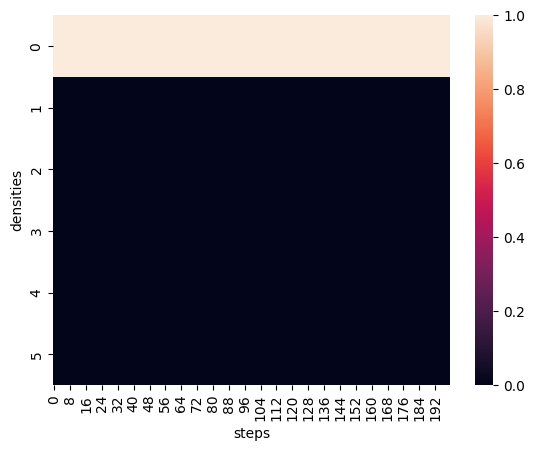

In [10]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")


Text(0, 0.5, 'Energy')

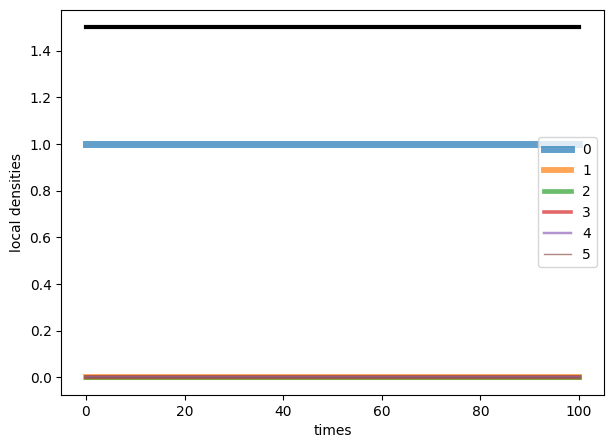

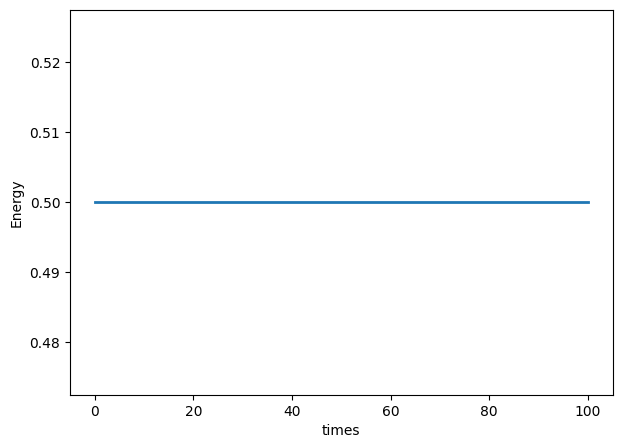

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=5.0-(0.8*i), label=i, alpha=0.7)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=3.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")
plt.legend()


fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")
